Function to plot the bounding box on the image:

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

def velocorners_to_imagecorners(point,calib_data):
    '''converts velo points to image points
    Based on the readme file for 3D object detection, x = P2 * R0_rect * Tr_velo_to_cam * y
    R0_rect contains a 3x3 matrix which you need to extend to a 4x4 matrix by adding a 1 as the bottom-right element 
    and 0's elsewhere.
    Tr_xxx is a 3x4 matrix (R|t), which you need to extend to a 4x4 matrix in the same way
    Remember, that calib data has to extracted for the relevant file instance
    
    Input: 
    point: 1 point in the velodyne coordinate, a list
    calib_data: calib file for that example
    
    Output:
    point in the 2D image coordinate as a 3 member list
    
    Scheme of i'''
    #appending the point with 1 for homogenization and making a numpy array
    point.append(1)
    point = np.array(point).reshape((4,1))
    
    R0_rect = calib_data["R0_rect"].reshape(3, 3)
    Tr_velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    P2 = calib_data["P2"].reshape(3, 4)
    
    R = np.zeros((4,4))
    R[:3,:3] = R0_rect
    R[3,3] = 1
    
    T = np.zeros((4,4))
    T[:3,:4] = Tr_velo_to_cam
    T[3,3] = 1
    
    point_image = np.dot(P2,np.dot(R,np.dot(T,point)))
    return list(np.squeeze(point_image.reshape(1,3)))
    
   
def draw_3D_boundingbox(box_corners, cl, calib_data, index, img_path, cl_prob):
    """Draws 3D bounding boxes
    Input:
    box_corners: a list of 8 box corners, each being a list with (x,y,z)
    cl: classification of object for that example, a string of Car, Van, or a Pedestrian
    calib_data: calib_data for that example
    index: example_index
    
    Output: plots figure along with saving it as BB_index.eps in the current directory
    """
    box_truth = labels[index]
    box_truth = np.squeeze(box_truth.reshape((1,8,3)))
    image = cv2.imread(img_path) #fill in the image path for this example 
    
    #order for finding points to line
    line_order = ([0, 1], [0, 3],[1, 5],[5, 7], [4, 7], [ 2,5], [6 ,7], [3, 6], [6, 1], [4, 3], [4 ,2], [0, 2])

    #color scheme for different objects
    type_c = { 'Car': (0, 0, 255), 'Van': (0, 255, 150), 'Pedestrian': (150,255,255) }
    
    type_c_gt = { 'Car': (255, 0, 0), 'Van': (255, 0, 0), 'Pedestrian': (255,0,0) }

    #have to feed 
    tracklet2d = []
    for i in box_corners:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d.append(point_image)
    tracklet2d = np.array(tracklet2d)
    
    tracklet2d_gt = []
    for i in box_truth:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d_gt.append(point_image)
    tracklet2d_gt = np.array(tracklet2d_gt)
    for k in line_order:    
        cv2.line(image, (int(tracklet2d[k[0]][0]), int(tracklet2d[k[0]][1])), (int(tracklet2d[k[1]][0]), int(tracklet2d[k[1]][1])), type_c[cl], 2)
        cv2.line(image, (int(tracklet2d_gt[k[0]][0]), int(tracklet2d_gt[k[0]][1])), (int(tracklet2d_gt[k[1]][0]), int(tracklet2d_gt[k[1]][1])), type_c_gt[cl], 2)
    
    iou = "{0:.2f}".format(IoU(box_corners, box_truth))
    cl_prob = "{0:.2f}".format(cl_prob)
    
   #making figure
    plt.subplots(1,1, figsize = (12,4))
    plt.title("Image with 3D bounding box; IOU = " + str(iou) +"  Class Probability = " + str(cl_prob) )
    plt.axis('off')
    plt.imshow(image)
    
    #fig.savefig('BB_'+str(index)+'.eps', format='eps', dpi=1200)
    
    

Function to calculate IOU:

In [22]:
#Evaluation metric
# 3D IoU python Implementation
# [IoU](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
from functools import reduce
def IoU(box0, box1):
  # box0: [x, y, z, d]
    l_a, b_a, h_a = abs(np.squeeze(box0[3:4] - box0[5:6]))
    l_b, b_b, h_b = abs(np.squeeze(box1[3:4] - box1[5:6]))
    d_a = np.array([l_a, b_a, h_a])
    d_b = np.array([l_b, b_b, h_b])
    
    box_a = [sum(box0[:][0])/8 , sum(box0[:][1])/8, sum(box0[:][2])/8]
    box_b = [sum(box1[:][0])/8 , sum(box1[:][1])/8, sum(box1[:][2])/8]
    
    r0 = d_a / 2
    
    s0 = np.squeeze(box_a - r0)
    e0 = np.squeeze(box_a + r0)
    r1 = d_b / 2
    s1 = np.squeeze(box_b - r1)
    e1 = np.squeeze(box_b + r1)
    overlap = [max(0,abs(min(e0[i], e1[i]) - max(s0[i], s1[i]))) for i in range(3)]
    intersection = reduce(lambda x,y:x*y, overlap)
    union = l_a*b_a*h_a + l_b*b_b*h_b - intersection
    return intersection / union

Load Data:

In [8]:
points =  np.load('train_points.npy')
labels = np.load('train_labels.npy')
labels = labels.reshape((7481,24))
classes = np.load('train_classes.npy')

(7481, 8, 3)


In [9]:

def read_calib_file(calib_path):
    """Read a calibration file."""
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if not line or line == "\n":
                continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data

Load Model:

In [10]:
import numpy as np
import sys
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input, Add, concatenate
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
import h5py
from matplotlib.pyplot import imshow
import glob
import math
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K

from keras.models import load_model


In [11]:
intermediate_output = np.load('intermediate_output.npy')
intermediate_output = np.squeeze(intermediate_output)
print(intermediate_output.shape)

(7481, 2048)


In [12]:
def mat_mul(A, B):
    return tf.matmul(A, B)


# number of points in each sample
num_points = 2048

# number of categories
k = 3

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
#x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
#f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
#g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Flatten()(global_feature)
# point_net_cls
#c = Dense(512, activation='relu')(global_feature)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(256, activation='relu')(c)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(k, activation='softmax')(c)
#prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

#Fusion

resnet_activation = Input(shape=(intermediate_output.shape[1],), name='intermediate_output')
f = Concatenate()([global_feature, resnet_activation])

#Definition of MLP Layer
f = Dense(512, activation='relu')(f)
f = Dense(128, activation='relu')(f)
f = Dense(128, activation='relu')(f)
boxes = Dense(labels.shape[-1])(f)
classes = Dense(classes.shape[-1])(f)


# print the model summary
model = Model(inputs=[input_points, resnet_activation], outputs=[boxes, classes])
model.load_weights('my_model_weights_450.h5')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2048, 3)      0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2048, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 2048, 64)     256         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 2048, 64)     4160        conv1d_15[0][0]                  
__________________________________________________________________________________________________
lambda_4 (

In [51]:
index = 3100
test_point = points[index:index+1]
test_class = classes[index:index+1]
test_label = labels[index:index+1]
test_intermediate = intermediate_output[index:index+1]
box, classes = model.predict([test_point, test_intermediate])
calib_path = "/Volumes/Hard Drive/data_object_calib/training/calib/003100.txt"
test_calib = read_calib_file(calib_path)
img_path = "/Volumes/Hard Drive/data_object_image_2/training/image_2/003100.png"
box = np.squeeze(box.reshape((box.shape[0], 8,3)))

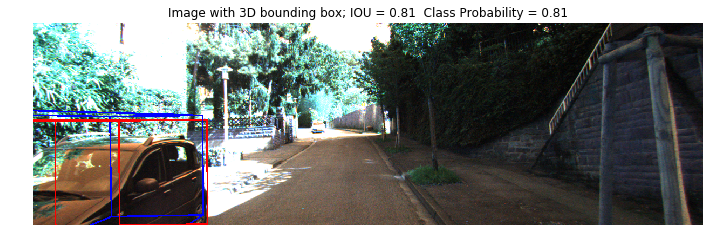

In [53]:
#prediction
draw_3D_boundingbox(box, 'Car', test_calib, index, img_path, np.max(classes))


In [54]:
#ground truth and IOU
indices = np.load('permuted_indices.npy')
test_idx = indices[7115:]
test_iou = []
for i in test_idx:
    test_point = points[i:i+1]
    test_intermediate = intermediate_output[i:i+1]
    box, classes = model.predict([test_point, test_intermediate])
    box = np.squeeze(box.reshape((box.shape[0], 8,3)))
    box_truth = labels[i]
    box_truth = np.squeeze(box_truth.reshape((1,8,3)))
    iou = IoU(box, box_truth)
    
    test_iou.append(iou)
    if(iou<0.5):
        print(i)
        print(iou)
avg_iou = sum(test_iou)/len(test_iou)
print(avg_iou)

1430
0.4607408253418204
5746
0.4160547286334302
2480
0.30271763289172976
6583
0.38230696939593956
4543
0.2061411446994923
1698
0.4446420091619638
4268
0.3624194409876482
2083
0.2945996337142382
3759
0.22446677907283188
7075
0.06685784131442321
5006
0.18512415692389464
6032
0.1571005290357974
5540
0.11181800941889944
2666
0.03617824741143367
2482
0.14052049085149235
5500
0.26189200625137027
3024
0.24989161881869923
2101
0.21486334122639977
7000
0.48200302218445246
6899
0.46596425622747006
5168
0.46724760579938845
2350
0.36751126258632383
3722
0.3375865066272423
2723
0.0030737984569815546
6559
0.4884015596147247
1570
0.2359649981974503
3883
0.445050006029327
7129
0.3854569245525108
6322
0.40278860138124817
6152
0.2998070815852893
4233
0.06741782813844067
3249
0.38758175094936304
6645
0.33926671811180464
1951
0.4011905254248926
2295
0.15483176168286217
5418
0.09596595694564561
2071
0.02983893284235886
5934
0.01447881914047713
4286
0.4275966883309079
2677
0.41731027326342746
5027
0.1154636

Showing some test results:

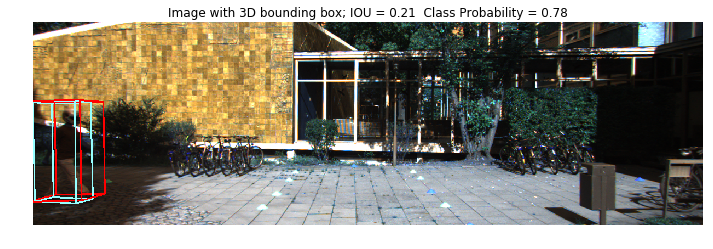

In [60]:
index = 4543
test_point = points[index:index+1]
test_class = classes[index:index+1]
test_label = labels[index:index+1]
test_intermediate = intermediate_output[index:index+1]
box, classes = model.predict([test_point, test_intermediate])
calib_path = "/Volumes/Hard Drive/data_object_calib/training/calib/004543.txt"
test_calib = read_calib_file(calib_path)
img_path = "/Volumes/Hard Drive/data_object_image_2/training/image_2/004543.png"
box = np.squeeze(box.reshape((box.shape[0], 8,3)))
#prediction
draw_3D_boundingbox(box, 'Pedestrian', test_calib, index, img_path, np.max(classes))

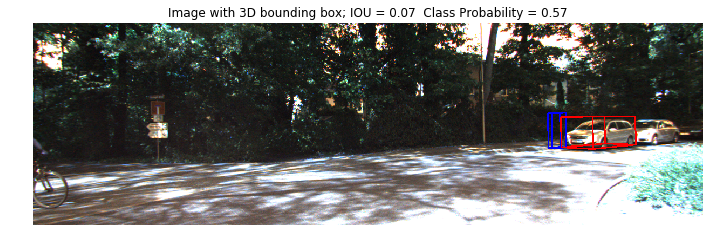

In [61]:
index =4233
test_point = points[index:index+1]
test_class = classes[index:index+1]
test_label = labels[index:index+1]
test_intermediate = intermediate_output[index:index+1]
box, classes = model.predict([test_point, test_intermediate])
calib_path = "/Volumes/Hard Drive/data_object_calib/training/calib/004233.txt"
test_calib = read_calib_file(calib_path)
img_path = "/Volumes/Hard Drive/data_object_image_2/training/image_2/004233.png"
box = np.squeeze(box.reshape((box.shape[0], 8,3)))
#prediction
draw_3D_boundingbox(box, 'Car', test_calib, index, img_path, np.max(classes))